In [1]:
import os
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import cv2
import numpy as np

def masks_to_boxes(mask_path, image_id, annotation_id, img):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    annotations = []
    scale_x = img.shape[1] / mask.shape[1]
    scale_y = img.shape[0] / mask.shape[0]

    _, binary_mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

    kernel = np.ones((3, 3), np.uint8)
    processed_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel, iterations=2)

    contours, _ = cv2.findContours(processed_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)

        if w * h < 50:  
            continue

        x, y, w, h = max(0, x), max(0, y), min(w, mask.shape[1] - x), min(h, mask.shape[0] - y)

        annotations.append({
            "id": annotation_id,
            "image_id": image_id,
            "bbox": [int(x * scale_x), int(y * scale_y), int(w * scale_x), int(h * scale_y)],
            "area": int(w * scale_x * h * scale_y),
        })
        annotation_id += 1

    return annotations, annotation_id


In [3]:
# https://github.com/facebookresearch/segment-anything
# https://pytorch.org/vision/stable/_modules/torchvision/ops/boxes.html#masks_to_boxes
# https://docs.opencv.org/4.x/da/d0c/tutorial_bounding_rects_circles.html

def masks_to_boxes(mask_path, image_id, annotation_id, img):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    # print(mask.shape)
    # print(img.shape)
    annotations = []


    scale_x = img.shape[1] / mask.shape[1]
    scale_y = img.shape[0] / mask.shape[0]

    
    # unique, counts = np.unique(mask, return_counts=True)
    # background_label = unique[np.argmax(counts)]

    # print(background_label)

    background_label = 16

    unique_labels = np.unique(mask)

    
    for label in unique_labels:
        if label == background_label: 
            continue
        
        binary_mask = (mask == label).astype(np.uint8) * 255
        contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            annotations.append({
                "id": annotation_id,
                "image_id": image_id,
                "category_id": int(label),
                "bbox": [int(x * scale_x), int(y * scale_y),int( w * scale_x), int(h * scale_y)],
                "area": int(w * scale_x * h * scale_y),
            })
            annotation_id += 1
    
    return annotations, annotation_id   

In [4]:

image_id = 1
annotation_id = 1
unique_labels = set()

dataset = []

root_dir = "/home/walke/college/cv/ass3/CV_A3/Q3/data/data"



for folder in sorted(os.listdir(root_dir)):
    folder_path = os.path.join(root_dir, folder)

    if not os.path.isdir(folder_path):
        continue
        
    for file_name in sorted(os.listdir(folder_path)):
        if file_name.endswith(".jpg"):
            img_path = os.path.join(folder_path, file_name)
            mask_path = os.path.join(folder_path, file_name.replace(".jpg", "_m.png"))
                
            if os.path.exists(mask_path):
                img = cv2.imread(img_path)
                height, width, _ = img.shape
                    
                image_info = {
                    "id": image_id,
                    "file_name": img_path,
                    "width": width,
                    "height": height
                }
                    
                img_annotations, annotation_id = masks_to_boxes(mask_path, image_id, annotation_id, img)


                dataset.append({
                        "image": image_info,
                        "annotations": img_annotations
                    })
                    
                image_id += 1
                    

                    
   
output_json = "/home/walke/college/cv/ass3/assignment-3-walkeee3/q3/q3.json"
with open(output_json, "w") as f:
    json.dump(dataset, f, indent=4)
    
# print(f"Annotations saved to {output_json}")

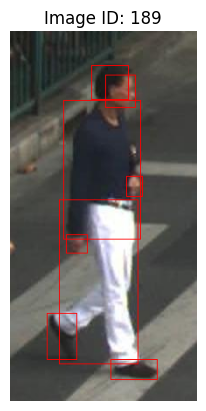

In [5]:
def visualize(path, image_id):

    with open(path, "r") as f:
        data = json.load(f)

    entry = None
    for item in data:
        if item["image"]["id"] == image_id:
            entry = item
            break  
    
    if entry is None:
        print(f"no image with this id")
        return
    
    image_info = entry["image"]
    img_path = image_info["file_name"]
    
    if not os.path.exists(img_path):
        print(f"Image file not found: {img_path}")
        return
    
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    for ann in entry["annotations"]:
        x, y, w, h = ann["bbox"]
        cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 1)

    plt.imshow(img)
    plt.title(f"Image ID: {image_id}")
    plt.axis("off")
    plt.show()

# Example usage:
visualize(output_json, image_id=189)


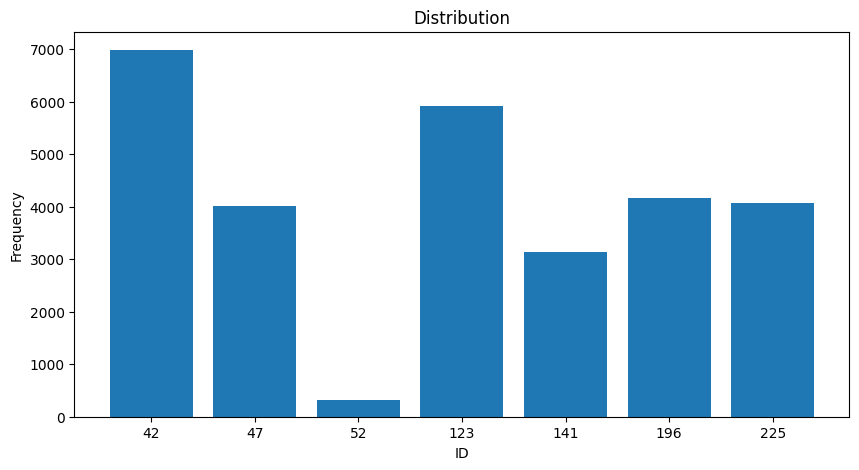

In [6]:

with open(output_json, "r") as f:
    data = json.load(f)
    
categories = {}

for entry in data:
    for annotation in entry["annotations"]:
        category_id = annotation["category_id"]
        if category_id in categories:
            categories[category_id] += 1
        else:
            categories[category_id] = 1

category_ids = sorted(categories.keys())
frequencies = [categories[cid] for cid in category_ids]
category_labels = [str(cid) for cid in category_ids]

plt.figure(figsize=(10, 5))
plt.bar(category_labels, frequencies)
plt.xlabel("ID")
plt.ylabel("Frequency")
plt.title("Distribution")
plt.show()




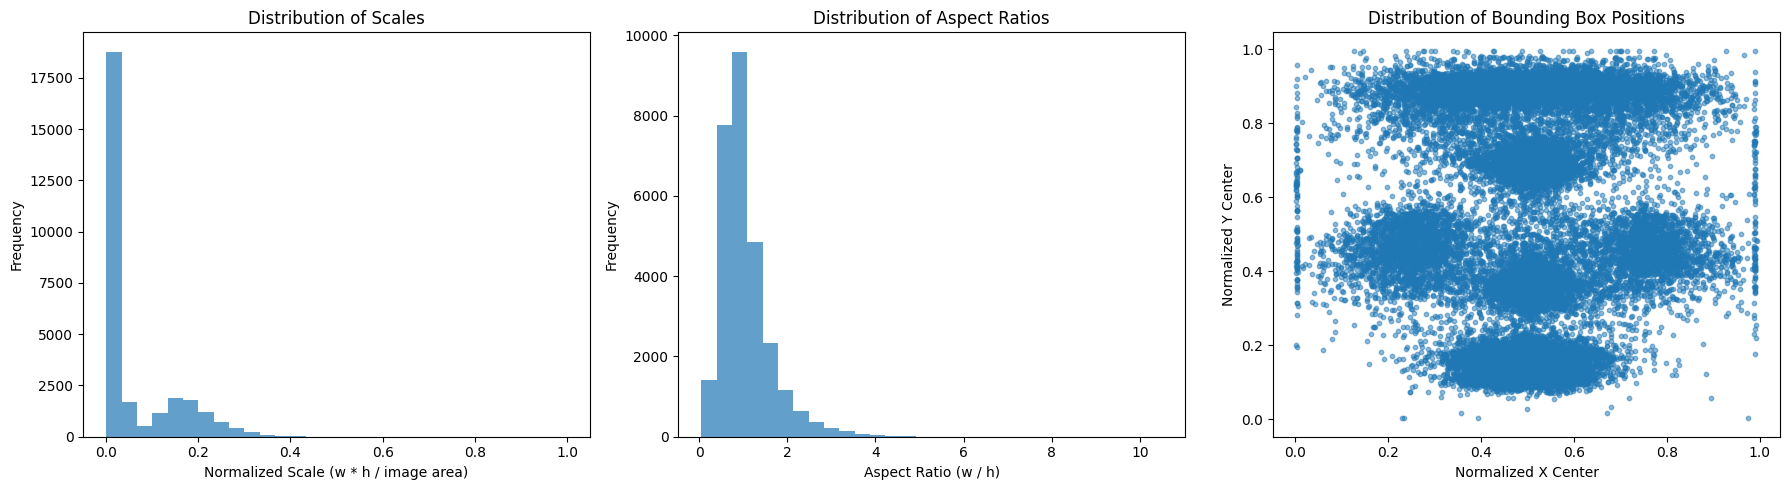

In [7]:

with open(output_json, "r") as f:
    data = json.load(f)

scales = []
aspect_ratios = []
positions_x = []
positions_y = []

for entry in data:
    img_width = entry["image"]["width"]
    img_height = entry["image"]["height"]

    for annotation in entry["annotations"]:
        x, y, w, h = annotation["bbox"]
            
        scale = (w * h) / (img_width * img_height)
        scales.append(scale)

        if h > 0: 
            aspect_ratio = w / h
            aspect_ratios.append(aspect_ratio)

        x_center = (x + w / 2) / img_width
        y_center = (y + h / 2) / img_height
        positions_x.append(x_center)
        positions_y.append(y_center)


fig, axes = plt.subplots(1, 3, figsize=(18, 5))


axes[0].hist(scales, bins=30, alpha=0.7)
axes[0].set_title("Distribution of Scales")
axes[0].set_xlabel("Normalized Scale (w * h / image area)")
axes[0].set_ylabel("Frequency")

axes[1].hist(aspect_ratios, bins=30, alpha=0.7)
axes[1].set_title("Distribution of Aspect Ratios")
axes[1].set_xlabel("Aspect Ratio (w / h)")
axes[1].set_ylabel("Frequency")

axes[2].scatter(positions_x, positions_y, alpha=0.5, s=10)
axes[2].set_title("Distribution of Bounding Box Positions")
axes[2].set_xlabel("Normalized X Center")
axes[2].set_ylabel("Normalized Y Center")


plt.tight_layout()
plt.show()





### **Plot 1**
- A right-tailed distribution, meaning few bounding boxes are large. Most bounding boxes occupy a small part of the image area.
- Small objects might be harder for a model to detect due to less number of pixel information.

### **Plot 2**
- The majority of baspect ratio almost 1 so most are they are almost square.

### **Plot 3**
- in this human dataset, the symmetry means left and right body parts are equally represented.
- the topmost cluster likely represents the hair and head. it is the largest cluster as most humans have their heaad
- the three cluster in the middle are likely the torso and the hands and the bottom most the legs,
- it might be hard for the model to detect the classes in different locations 



In [8]:
from sklearn.model_selection import train_test_split

split = 0.2
train_set, val_set = train_test_split(dataset, test_size=split, random_state=42)
    

In [9]:
len(dataset)

3961

**Faster R-CNN** is a good choice

- parts detection in humans needs to locate small parts which needs accuracy which faster rcnn does
- faster rcnns uses rpns which allows for detecting overlapping objects as this is common in the human body]
- you can choose appropriate backbone so it is flexible


In [10]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

In [11]:
# https://pytorch.org/vision/main/generated/torchvision.transforms.ColorJitter.html
from PIL import Image

def color_jitter(image: Image.Image, target: dict,
                         brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1):
    color_jitter = transforms.ColorJitter(brightness=brightness,
                                 contrast=contrast,
                                 saturation=saturation,
                                 hue=hue)
    jittered_image = color_jitter(image)
    return jittered_image, target



In [12]:

from torchvision.transforms import RandomAffine
import torchvision.transforms.functional as F


def random_affine(image, target, degrees=15, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=0, fill=0, center=None):
    h, w = image.shape[:2]
    if center is None:
        center = (w * 0.5, h * 0.5)
    params = RandomAffine.get_params(degrees=(-degrees, degrees),
                                     translate=translate,
                                     scale_ranges=scale,
                                     shears=[-shear, shear],
                                     img_size=(h, w))
    angle, translations, scale_factor, shear_factor = params

    transformed_image = cv2.warpAffine(image,
                                       cv2.getRotationMatrix2D(center, angle, scale_factor) + np.array([[0, 0, translations[0]], [0, 0, translations[1]]]),
                                       (w, h),
                                       flags=cv2.INTER_LINEAR,
                                       borderMode=cv2.BORDER_REFLECT_101)
    
    angle_rad = np.deg2rad(angle)
    R = np.array([[np.cos(angle_rad) * scale_factor, -np.sin(angle_rad) * scale_factor],
                  [np.sin(angle_rad) * scale_factor,  np.cos(angle_rad) * scale_factor]])
    T = np.array(translations)

    def transform_box(box):
        corners = np.array([
            [box[0], box[1]],
            [box[2], box[1]],
            [box[2], box[3]],
            [box[0], box[3]]
        ])
        corners_centered = corners - np.array(center)
        transformed = np.dot(corners_centered, R.T)
        transformed = transformed + np.array(center) + T
        x_min, y_min = transformed[:, 0].min(), transformed[:, 1].min()
        x_max, y_max = transformed[:, 0].max(), transformed[:, 1].max()
        return [x_min, y_min, x_max, y_max]

    boxes = target["boxes"].float().clone().numpy()
    new_boxes = [transform_box(box) for box in boxes]
    new_boxes = torch.tensor(new_boxes, dtype=torch.float32)


    new_boxes[:, 0] = new_boxes[:, 0].clamp(0, w)
    new_boxes[:, 1] = new_boxes[:, 1].clamp(0, h)
    new_boxes[:, 2] = new_boxes[:, 2].clamp(0, w)
    new_boxes[:, 3] = new_boxes[:, 3].clamp(0, h)


    keep = (new_boxes[:, 2] > new_boxes[:, 0]) & (new_boxes[:, 3] > new_boxes[:, 1])
    new_boxes = new_boxes[keep]


    new_boxes = new_boxes.round().to(torch.int64)

    target["boxes"] = new_boxes
    if "labels" in target:
        target["labels"] = target["labels"][keep]
    if "iscrowd" in target:
        target["iscrowd"] = target["iscrowd"][keep]
    
    areas = (new_boxes[:, 2] - new_boxes[:, 0]) * (new_boxes[:, 3] - new_boxes[:, 1])
    target["area"] = areas.to(torch.int64)
    
    return transformed_image, target



In [13]:
import random 


def compose_transforms(image, target):

    # image_np = (image.mul(255).permute(1, 2, 0).cpu().numpy()).astype(np.uint8)
    # if random.random() < 0.3:   
    #     image_np, target = random_affine(image_np, target, degrees=15, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=0, fill=0, center=None)

    # pil_img = Image.fromarray(image_np)

    # if random.random() < 0.3:     
    #     pil_img, target = color_jitter(pil_img, target, brightness=0.3, contrast=0.3, saturation=0.3, hue=0.05)

    # image = F.to_tensor(pil_img)

    return image, target

In [14]:
print(category_labels)
category_labels.append("16")
print(category_labels)
label_mapping = {label: i+1 for i, label in enumerate(category_labels)}
print("Label Mapping:", label_mapping)
label_mapping['42']

['42', '47', '52', '123', '141', '196', '225']
['42', '47', '52', '123', '141', '196', '225', '16']
Label Mapping: {'42': 1, '47': 2, '52': 3, '123': 4, '141': 5, '196': 6, '225': 7, '16': 8}


1

In [15]:
class PartsDataset(Dataset):
    def __init__(self, json_path, transform=None):
        with open(json_path, "r") as f:
            self.data = json.load(f)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_info = self.data[idx]["image"]
        annotations = self.data[idx]["annotations"]
        
        img = cv2.imread(image_info["file_name"])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (image_info["width"], image_info["height"]))
        img = F.to_tensor(img)
        img = F.normalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])


        boxes = []
        labels = []
        areas = []

        for annotation in annotations:
            x, y, w, h = annotation["bbox"]
            category_name = annotation["category_id"] 

            if str(category_name) not in label_mapping:
                raise ValueError(f"Unknown category: {category_name}")
            category_id = label_mapping[str(category_name)]  

            boxes.append([x, y, x + w, y + h])
            labels.append(category_id) 
            areas.append(annotation["area"])

        boxes = torch.as_tensor(boxes, dtype=torch.int64)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        areas = torch.as_tensor(areas, dtype=torch.int64)
        iscrowd = torch.zeros((len(boxes),), dtype=torch.int64)

        target = {"boxes": boxes, "labels": labels, "image_id": torch.tensor([image_info["id"]]), "area": areas, "iscrowd": iscrowd}

        if self.transform:
            img, target = self.transform(img, target)

        return img, target


In [16]:
print(category_labels)

['42', '47', '52', '123', '141', '196', '225', '16']


In [18]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [19]:
# https://medium.com/@RobuRishabh/understanding-and-implementing-faster-r-cnn-248f7b25ff96
# https://www.researchgate.net/publication/315216231_Multiple-Branches_Faster_RCNN_for_Human_Parts_Detection_and_Pose_Estimation

- we only need the convolutional feature maps from resnet50 and not the classification head. so we remove the last fully connected layer as that is for object classification and not for bounding boxes

- the part based detection needs spatial information so we remove the avg pooling layer of resnet50 as it collapse the 2D structure into a single vector

- the number of classes are also taken from the prev graphs + 1 for the background.

- the anchor_sizes have been chosen for smaller object detection as we know most bounding boxes are small compared to the picture

- the aspect ratios suggest that ther is majority of square and slightly vertically elongated boxes, as the distribution is a right tailed graph.


In [20]:
%env CUDA_LAUNCH_BLOCKING 1

import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
import torch.nn as nn



backbone = torchvision.models.resnet50(weights="IMAGENET1K_V1")

modules = list(backbone.children())[:-2]  
backbone = nn.Sequential(*modules)

backbone.out_channels = 2048

anchor_sizes = ((16, 32, 64, 128),)
aspect_ratios = ((0.5, 1.0, 2.0),)

anchor_generator = AnchorGenerator(sizes=anchor_sizes,
                                aspect_ratios=aspect_ratios)

model = FasterRCNN(
        backbone=backbone,
        num_classes=8,
        rpn_anchor_generator=anchor_generator,
        box_detections_per_img=10
    )

print(model)
model = model.to(device)




env: CUDA_LAUNCH_BLOCKING=1
FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(

In [21]:

def remove_background_predictions(predictions):
    filtered_predictions = []
    
    for prediction in predictions:
        boxes = prediction['boxes']
        labels = prediction['labels']
        scores = prediction['scores']

        keep = labels != 8
        filtered_predictions.append({
            "boxes": boxes[keep],
            "labels": labels[keep],
            "scores": scores[keep]
        })

    return filtered_predictions

TOP_K = 10


def filter_predictions(predictions, top_k=TOP_K):
    filtered_predictions = []
    
    for prediction in predictions:
        boxes = prediction['boxes']
        labels = prediction['labels']
        scores = prediction['scores']

        top_k_indices = torch.argsort(scores, descending=True)[:top_k]  

        filtered_predictions.append({
            "boxes": boxes[top_k_indices],
            "labels": labels[top_k_indices],
            "scores": scores[top_k_indices]
        })

    return filtered_predictions



In [22]:
from tqdm import tqdm
import gc

def train_loop(dataloader, model, optimizer, device):
    model.train()  
    total_loss = 0.0
    num_batches = len(dataloader)

    for images, targets in tqdm(dataloader, desc="Training", total=num_batches):

        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        total_loss += loss_value

        losses.backward()
        optimizer.step()

    torch.cuda.empty_cache()
    gc.collect()

    avg_loss = total_loss / num_batches
    print(f"Training: Average Loss: {avg_loss:.6f}")

def val_loop(dataloader, model, device, num_images=5):
    model.eval()  
    predictions_list = []
    images_list = []

    with torch.no_grad():
        for images, _ in tqdm(dataloader, desc="Validation"):
            images = [img.to(device) for img in images] 
            predictions = model(images)  

            predictions = [{k: v.cpu() for k, v in p.items()} for p in predictions]

            predictions = remove_background_predictions(predictions)

            predictions = filter_predictions(predictions)

            for img, pred in zip(images, predictions):
                if len(images_list) < num_images:
                    images_list.append(img.cpu())  
                    predictions_list.append(pred)
                if len(images_list) >= num_images:
                    break 

            if len(images_list) >= num_images:
                break  

    print(f"Stored {len(images_list)} images for visualization.")
    return images_list, predictions_list

def test_loop(dataloader, model, device):
    model.eval()
    total_loss = 0.0
    num_batches = len(dataloader)

    with torch.no_grad():
        for images, targets in tqdm(dataloader, desc="Testing", total=num_batches):
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            total_loss += losses.item()

    avg_loss = total_loss / num_batches
    print(f"Testing: Average Loss: {avg_loss:.6f}")
    return avg_loss


In [23]:

import torch.optim as optim

learning_rate = 1e-3
epochs = 5

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_loop(train_dataloader, model, optimizer, device)
    # val_loss = val_loop(val_dataloader, model, device)
    # print(f"Validation Loss: {val_loss:.6f}\n")
    
print("Training complete!")


Epoch 1
-------------------------------


Training: 100%|██████████| 634/634 [04:36<00:00,  2.29it/s]


Training: Average Loss: 1.453761
Epoch 2
-------------------------------


Training: 100%|██████████| 634/634 [04:30<00:00,  2.34it/s]


Training: Average Loss: 1.373390
Epoch 3
-------------------------------


Training: 100%|██████████| 634/634 [04:28<00:00,  2.36it/s]


Training: Average Loss: 1.200894
Epoch 4
-------------------------------


Training: 100%|██████████| 634/634 [04:25<00:00,  2.39it/s]


Training: Average Loss: 1.148641
Epoch 5
-------------------------------


Training: 100%|██████████| 634/634 [04:27<00:00,  2.37it/s]


Training: Average Loss: 1.132112
Training complete!


Validation:   6%|▌         | 9/159 [00:01<00:20,  7.35it/s]

Stored 10 images for visualization.


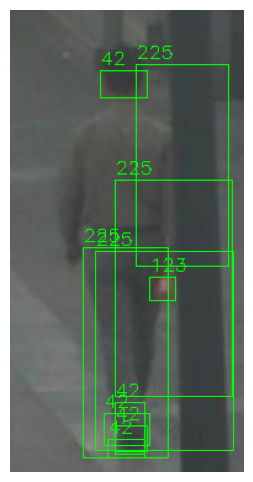

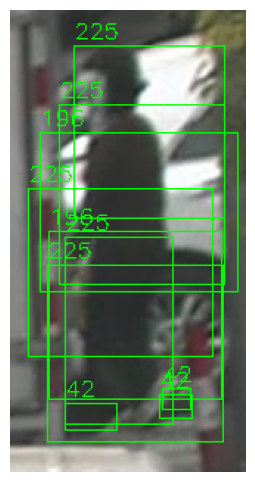

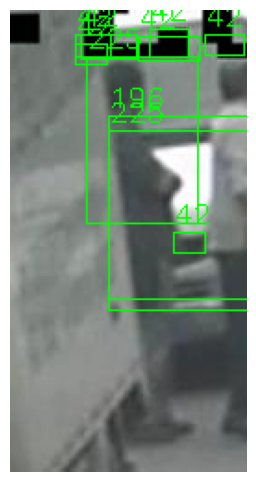

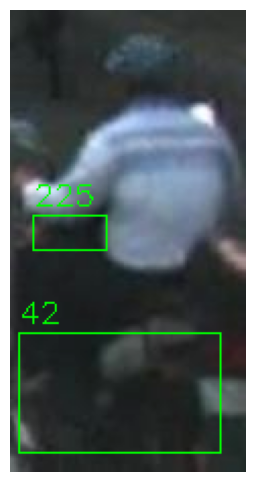

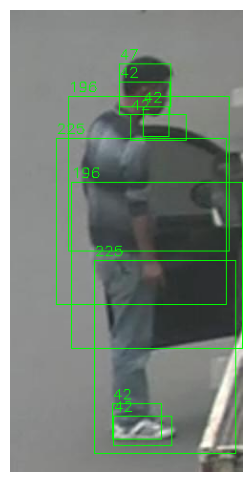

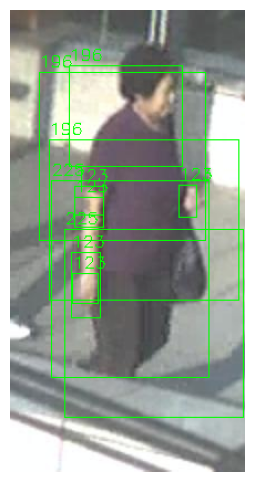

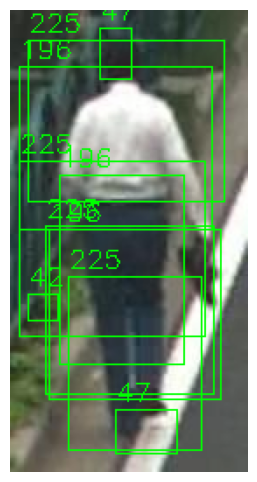

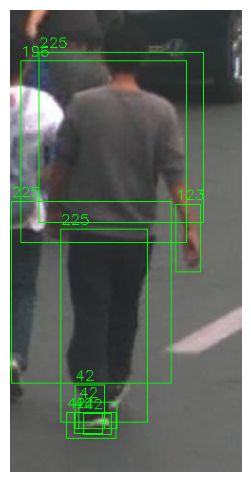

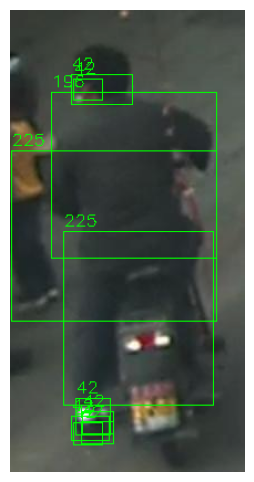

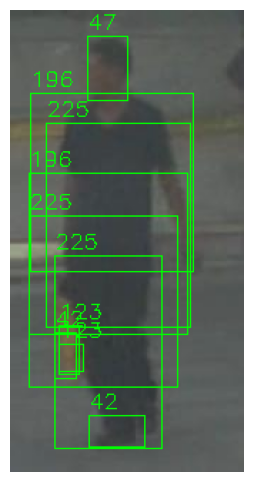

In [24]:
IMAGENET_MEAN = np.array([0.485, 0.456, 0.406])
IMAGENET_STD = np.array([0.229, 0.224, 0.225])

def unnormalize_image(image):
    """Reverse the normalization applied by Faster R-CNN."""
    image = image.permute(1, 2, 0).cpu().numpy()  # Convert (C, H, W) → (H, W, C)
    image = (image * IMAGENET_STD) + IMAGENET_MEAN  # Unnormalize
    image = (image * 255).astype(np.uint8)  # Convert back to 0-255 range
    return image

def visualize_prediction(image, prediction, class_names):
    img = unnormalize_image(image)

    boxes = prediction['boxes']
    labels = prediction['labels']

    img_cv2 = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

    for box, label in zip(boxes, labels):
        x_min, y_min, x_max, y_max = map(int, box)
        class_name = class_names[label - 1] 

        cv2.rectangle(img_cv2, (x_min, y_min), (x_max, y_max), (0, 255, 0), 1)

        cv2.putText(img_cv2, class_name, (x_min, y_min - 5), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

    img_rgb = cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB)

    # Display the image
    plt.figure(figsize=(8, 6))
    plt.imshow(img_rgb)
    plt.axis("off")
    plt.show()


val_images, val_predictions = val_loop(val_dataloader, model, device, num_images=10)

for i in range(len(val_images)):
    visualize_prediction(val_images[i], val_predictions[i], category_labels)



In [25]:
import torch
import torchvision.ops as ops
import numpy as np
from tqdm import tqdm

def compute_ap(gt_boxes, pred_boxes, scores, iou_threshold=0.5):
    if len(pred_boxes) == 0:
        return 0

    sorted_indices = torch.argsort(scores, descending=True)
    pred_boxes = pred_boxes[sorted_indices]

    ious = ops.box_iou(pred_boxes, gt_boxes)
    
    tp = torch.zeros(len(pred_boxes))
    fp = torch.zeros(len(pred_boxes))
    matched = torch.zeros(len(gt_boxes), dtype=torch.bool)

    for pred_idx, box in enumerate(pred_boxes):
        max_iou, max_gt_idx = ious[pred_idx].max(0)

        if max_iou >= iou_threshold and not matched[max_gt_idx]:
            tp[pred_idx] = 1  
            matched[max_gt_idx] = True
        else:
            fp[pred_idx] = 1  

    tp_cumsum = torch.cumsum(tp, dim=0)
    fp_cumsum = torch.cumsum(fp, dim=0)

    recalls = tp_cumsum / max(len(gt_boxes), 1)
    precisions = tp_cumsum / (tp_cumsum + fp_cumsum + 1e-6)

    recalls_np = recalls.numpy()
    precisions_np = precisions.numpy()
    ap = np.trapz(precisions_np, recalls_np)  

    return ap


def evaluate_map(model, dataloader, device, iou_thresholds=[0.25, 0.5]):
    model.eval()
    
    aps_per_threshold = {iou: [] for iou in iou_thresholds}

    with torch.no_grad():
        for images, targets in tqdm(dataloader, desc="Evaluating mAP"):
            images = [img.to(device) for img in images]
            predictions = model(images) 
            
            predictions = [{k: v.cpu() for k, v in p.items()} for p in predictions]
            targets = [{k: v.cpu() for k, v in t.items()} for t in targets]

            for pred, target in zip(predictions, targets):
                pred_boxes = pred["boxes"]
                pred_scores = pred["scores"]
                gt_boxes = target["boxes"]

                for iou in iou_thresholds:
                    ap = compute_ap(gt_boxes, pred_boxes, pred_scores, iou_threshold=iou)
                    aps_per_threshold[iou].append(ap)

    mean_aps = {iou: np.mean(aps) for iou, aps in aps_per_threshold.items()}

    return mean_aps


# Example Usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mAP_results = evaluate_map(model, val_dataloader, device)

for iou, ap in mAP_results.items():
    print(f"mAP at IoU {iou:.2f}: {ap:.4f}")


Evaluating mAP:   0%|          | 0/159 [00:00<?, ?it/s]/tmp/ipykernel_164567/3108961024.py:36: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  ap = np.trapz(precisions_np, recalls_np)
Evaluating mAP: 100%|██████████| 159/159 [00:17<00:00,  8.98it/s]

mAP at IoU 0.25: 0.2597
mAP at IoU 0.50: 0.1500


Extracting Predictions: 100%|██████████| 159/159 [00:18<00:00,  8.55it/s]


Category 1: Precision = 0.1756, Recall = 0.2553
Category 2: Precision = 0.0805, Recall = 0.0864
Category 3: Precision = 0.0000, Recall = 0.0000
Category 4: Precision = 0.2092, Recall = 0.2024
Category 5: Precision = 0.0345, Recall = 0.0157
Category 6: Precision = 0.1061, Recall = 0.2000
Category 7: Precision = 0.0923, Recall = 0.1890


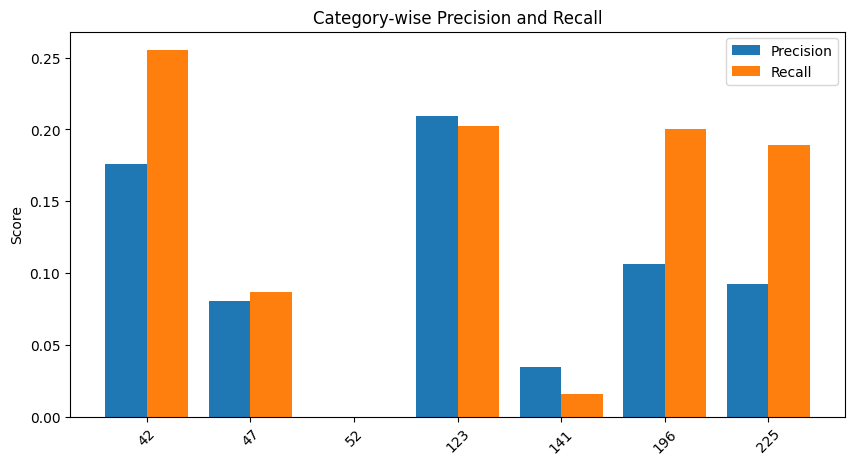

In [26]:
from sklearn.metrics import precision_score, recall_score

def compute_partwise_metrics(predictions, targets, num_classes):
    all_preds = []
    all_targets = []

    for pred, target in zip(predictions, targets):
        pred_labels = pred["labels"].tolist() if "labels" in pred else []  
        target_labels = target["labels"].tolist() if "labels" in target else []

        all_preds.extend(pred_labels)
        all_targets.extend(target_labels)

    max_len = max(len(all_preds), len(all_targets))
    all_preds.extend([0] * (max_len - len(all_preds)))
    all_targets.extend([0] * (max_len - len(all_targets)))

    precision = precision_score(all_targets, all_preds, average=None, labels=range(1, num_classes+1), zero_division=0)
    recall = recall_score(all_targets, all_preds, average=None, labels=range(1, num_classes+1), zero_division=0)

    for i, (p, r) in enumerate(zip(precision, recall)):
        print(f"Category {i+1}: Precision = {p:.4f}, Recall = {r:.4f}")

    return precision, recall


def get_predictions_targets(dataloader, model, device):
    model.eval()
    predictions_list = []
    targets_list = []

    with torch.no_grad():
        for images, targets in tqdm(dataloader, desc="Extracting Predictions"):
            images = [img.to(device) for img in images]
            predictions = model(images)  

            predictions = [{k: v.cpu() for k, v in p.items()} for p in predictions]
            targets = [{k: v.cpu() for k, v in t.items()} for t in targets]

            predictions_list.extend(predictions)
            targets_list.extend(targets)

    return predictions_list, targets_list

def plot_categorywise_performance(predictions, targets, category_labels):
    num_classes = 7
    precision, recall = compute_partwise_metrics(predictions, targets, num_classes)

    x = np.arange(num_classes)
    width = 0.4

    plt.figure(figsize=(10, 5))
    plt.bar(x - width/2, precision, width, label="Precision")
    plt.bar(x + width/2, recall, width, label="Recall")

    plt.xticks(ticks=x, labels=category_labels[:num_classes] , rotation=45)
    plt.ylabel("Score")
    plt.title("Category-wise Precision and Recall")
    plt.legend()
    plt.show()

predictions, targets = get_predictions_targets(val_dataloader, model, device)

plot_categorywise_performance(predictions, targets, category_labels)



the reasons for the false positives are
- False Negatives (FN)
  - Small parts tend to be missed, especially if they blend with the background.  
  - Occluded parts are often not detected, particularly if another object overlaps them.  
  - Certain viewpoints make parts unrecognizable, leading to lower recall.  

- False Positives (FP) 
  - The model misclassifies background noise or similar textures as parts.  
  - Overlapping parts sometimes cause confusion, leading to incorrect part assignments.  
  - Inconsistent lighting conditions contribute to detecting non-existent parts.  


- Smaller parts have lower IoU values, leading to higher FN rates.  
- Larger parts are detected with higher confidence but sometimes get merged with nearby regions.  


- Severe occlusion significantly reduces part detection.  
- Partial occlusion sometimes leads to fragmented detections.  
- fewer occluded samples contributes to poor performance.  

 
- The dataset lacks diverse viewpoint samples, limiting generalization.  





- **improvements**

#### 1
- **Deformable Convolutions & FPNs** for better scale adaptation.  
- **Transformers (DETR)** to model part relationships.  

#### 2  
- **Augmentation:** More occlusion and viewpoint variations in training.  
- **Hard Negative Mining:** Reduce false positives.  
- **Occlusion-Aware Loss Functions:** Improve handling of hidden parts.  

#### 3
- **Graph Neural Networks (GNNs)** for structured reasoning.  
- **Hierarchical Detection:** Object first, then refine parts.  
- **Pose Estimation:** Infer missing parts based on spatial cues.  

